In [8]:
# ==================================================
# MATCH WINNER PREDICTION PIPELINE
# ==================================================

# Cell 1: Setup and Configuration
# ==================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path
import warnings
import os
import sys
from datetime import datetime
import optuna

# Sklearn imports
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance

# SMOTE for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'imbalanced-learn'])
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True

# XGBoost
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not installed.")

# Neural Network using scikit-learn MLPClassifier
from sklearn.neural_network import MLPClassifier
NN_AVAILABLE = True  # Always available with scikit-learn

# Configuration
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Paths
MODELS_DIR = Path('models')
VIZ_DIR = Path('visualizations/match_winner')
DATASETS_DIR = Path('datasets')
RAW_MATCH_DATA_PATH = DATASETS_DIR / 'Match Winner.csv'
FINAL_DATA_PATH = Path('data/match_winner/match_winner_data.csv')
REPORTS_DIR = Path('reports/match_winner')
DIAG_DIR = REPORTS_DIR / 'diagnostics'

# Create directories
for dir_path in [MODELS_DIR, VIZ_DIR, FINAL_DATA_PATH.parent, REPORTS_DIR, DIAG_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ==================================================
# UTILITY FUNCTIONS
# ==================================================

def check_data_quality(df):
    """
    Perform comprehensive data quality check.
    """
    print("Data Shape:", df.shape)
    print("\nMissing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
    print("\nDuplicate Rows:", df.duplicated().sum())
    
    # Check for constant columns
    constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
    if constant_cols:
        print("\nConstant Columns (to drop):", constant_cols)
    else:
        print("\nNo constant columns found.")

def tune_hyperparameters(model_class, X_train, y_train, param_fn, n_trials=20, cv=7, scoring='f1_macro', task_type='classification'):
    """
    Reusable Optuna hyperparameter tuning function.
    """
    def objective(trial):
        params = param_fn(trial)
        model = model_class(**params)
        
        if task_type == 'classification':
            cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
        else:
            cv_strategy = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
            
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring=scoring, n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

def evaluate_classification_model(model, X_test, y_test, model_name="Model", class_names=None):
    """
    Evaluate classification model and return metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    
    if y_prob is not None and len(np.unique(y_test)) > 2: # Multi-class AUC
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
            print(f"ROC AUC (Weighted OVR): {roc_auc:.4f}")
        except ValueError as e:
            print(f"Could not compute ROC AUC: {e}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'F1_Macro': f1_macro
    }

def plot_feature_importance(model, feature_names, top_n=20, model_name="Model"):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Adjust top_n to not exceed number of features
        n_features = len(feature_names)
        top_n = min(top_n, n_features)
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importances - {model_name}")
        plt.bar(range(top_n), importances[indices[:top_n]], align="center")
        plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature importance plotting (e.g., Keras, Logistic Regression).")

print("="*80)
print("MATCH WINNER PREDICTION PIPELINE")
print("="*80)
print(f"Setup completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"SMOTE Available: {SMOTE_AVAILABLE}")
print(f"XGBoost Available: {XGB_AVAILABLE}")
print(f"Neural Network (MLP) Available: {NN_AVAILABLE}")
print("="*80)


MATCH WINNER PREDICTION PIPELINE
Setup completed at: 2025-11-20 12:46:19
SMOTE Available: True
XGBoost Available: True
Neural Network (MLP) Available: True


In [9]:
# Cell 2: Data Loading and Advanced Feature Engineering
# ==================================================
import pandas as pd
import numpy as np
from pathlib import Path

# Ensure necessary functions and paths (like check_data_quality, RAW_MATCH_DATA_PATH, FINAL_DATA_PATH) 
# are defined in a previous cell.

def load_match_data(file_path):
    """
    Load match data, standardize column names, and ensure the target column exists.
    """
    print("\n" + "="*80)
    print("DATA LOADING")
    print("="*80)
    
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")
        
    df = pd.read_csv(file_path)
    
    # Standardize columns
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # --- FIX: Standardize target column ---
    # Look for common target column names and standardize to 'match_outcome'
    possible_target_names = {
        'ftr': 'match_outcome',
        'result': 'match_outcome',
        'final_result': 'match_outcome',
        'match_result': 'match_outcome'
    }
    
    renamed = False
    for name, new_name in possible_target_names.items():
        if name in df.columns and new_name not in df.columns:
            df.rename(columns={name: new_name}, inplace=True)
            print(f"✓ Standardized target column: Renamed '{name}' to '{new_name}'")
            renamed = True
            break
            
    if 'match_outcome' not in df.columns:
        print("! WARNING: Target column 'match_outcome' not found or standardized. Please check the CSV file.")

    # Quality Check
    check_data_quality(df)
    
    print("\nColumns:", df.columns.tolist())
    
    return df

def engineer_advanced_features(df):
    """
    Create advanced features for better prediction.
    """
    print("\n" + "="*80)
    print("ADVANCED FEATURE ENGINEERING")
    print("="*80)
    
    original_columns = df.columns.tolist()  # Store original columns
    df = df.copy()
    
    # Convert match result columns to numeric (they might be 'W', 'D', 'L' strings)
    match_cols = ['hm1', 'hm2', 'hm3', 'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5']
    for col in match_cols:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].map({'W': 3, 'D': 1, 'L': 0}).fillna(0).astype(float)
    
    # 1. Goal Difference Features
    df['home_goal_advantage'] = df['htgs'] - df['atgs']
    df['away_goal_advantage'] = df['atgs'] - df['htgs']
    df['home_defense_strength'] = df['htgs'] - df['htgc']
    df['away_defense_strength'] = df['atgs'] - df['atgc']
    
    # 2. Form Momentum
    df['form_momentum'] = df['htformpts'] - df['atformpts']
    df['form_ratio'] = df['htformpts'] / (df['atformpts'] + 1)
    
    # 3. Streak Features
    df['home_streak_advantage'] = df['htwinstreak3'] - df['atlossstreak3']
    df['away_streak_advantage'] = df['atwinstreak3'] - df['htlossstreak3']
    
    # 4. Points Pressure Features
    df['points_gap'] = df['diffpts']
    df['points_ratio'] = (df['htp'] + 1) / (df['atp'] + 1)
    
    # 5. Recent Match Features (weighted)
    df['home_recent_weighted'] = (df['hm1'] * 3 + df['hm2'] * 2 + df['hm3'] * 1) / 6
    df['away_recent_weighted'] = (df['am1'] * 3 + df['am2'] * 2 + df['am3'] * 1) / 6
    df['recent_form_diff'] = df['home_recent_weighted'] - df['away_recent_weighted']
    
    # 6. Attack vs Defense Matchup
    df['home_attack_vs_away_defense'] = df['htgs'] / (df['atgc'] + 1)
    df['away_attack_vs_home_defense'] = df['atgs'] / (df['htgc'] + 1)
    
    # 7. Goal Scoring Efficiency
    df['home_goal_efficiency'] = df['htgs'] / (df['mw'] + 1)
    df['away_goal_efficiency'] = df['atgs'] / (df['mw'] + 1)
    df['goal_efficiency_diff'] = df['home_goal_efficiency'] - df['away_goal_efficiency']
    
    # 8. Consistency Features
    home_recent_matches = df[['hm1', 'hm2', 'hm3', 'hm4', 'hm5']].values
    away_recent_matches = df[['am1', 'am2', 'am3', 'am4', 'am5']].values
    df['home_consistency'] = -np.var(home_recent_matches, axis=1)
    df['away_consistency'] = -np.var(away_recent_matches, axis=1)
    
    # 9. Interaction Features
    df['gd_x_formpts'] = df['htgd'] * df['htformpts']
    df['streak_x_points'] = df['htwinstreak3'] * df['htp']
    
    # 10. Polynomial Features
    df['htgd_squared'] = df['htgd'] ** 2
    df['diffpts_squared'] = df['diffpts'] ** 2
    
    # --- FIX: Calculate new features without recalling load_match_data ---
    new_features = [col for col in df.columns if col not in original_columns]
    print(f"✓ Created {len(new_features)} new features")
    print(f"✓ Total features: {df.shape[1]}")
    
    return df

# --- Execution ---
df = load_match_data(RAW_MATCH_DATA_PATH)
df = engineer_advanced_features(df)
df.to_csv(FINAL_DATA_PATH, index=False)


DATA LOADING
✓ Standardized target column: Renamed 'ftr' to 'match_outcome'
Data Shape: (6840, 40)

Missing Values:
 Series([], dtype: int64)

Duplicate Rows: 0

No constant columns found.

Columns: ['unnamed:_0', 'date', 'hometeam', 'awayteam', 'fthg', 'ftag', 'match_outcome', 'htgs', 'atgs', 'htgc', 'atgc', 'htp', 'atp', 'hm1', 'hm2', 'hm3', 'hm4', 'hm5', 'am1', 'am2', 'am3', 'am4', 'am5', 'mw', 'htformptsstr', 'atformptsstr', 'htformpts', 'atformpts', 'htwinstreak3', 'htwinstreak5', 'htlossstreak3', 'htlossstreak5', 'atwinstreak3', 'atwinstreak5', 'atlossstreak3', 'atlossstreak5', 'htgd', 'atgd', 'diffpts', 'diffformpts']

ADVANCED FEATURE ENGINEERING
✓ Created 24 new features
✓ Total features: 64



EXPLORATORY DATA ANALYSIS (EDA)
Temporarily encoded 'match_outcome' for visualization.

Distribution of Target Variable: 'match_outcome'


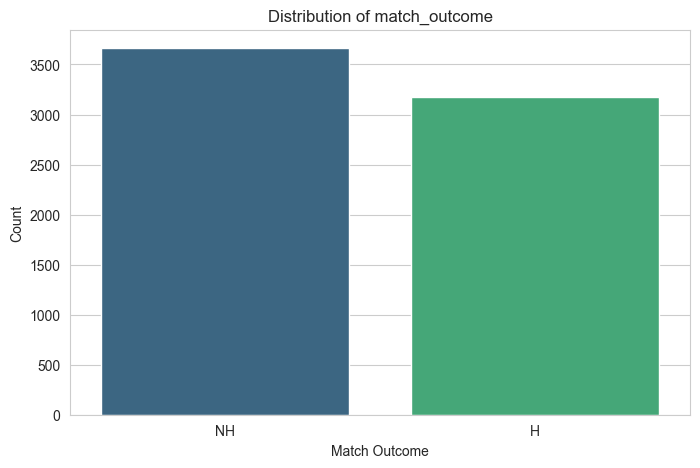


Generating Correlation Matrix for a curated subset of non-betting features...
-> Plotting correlation for 16 features.


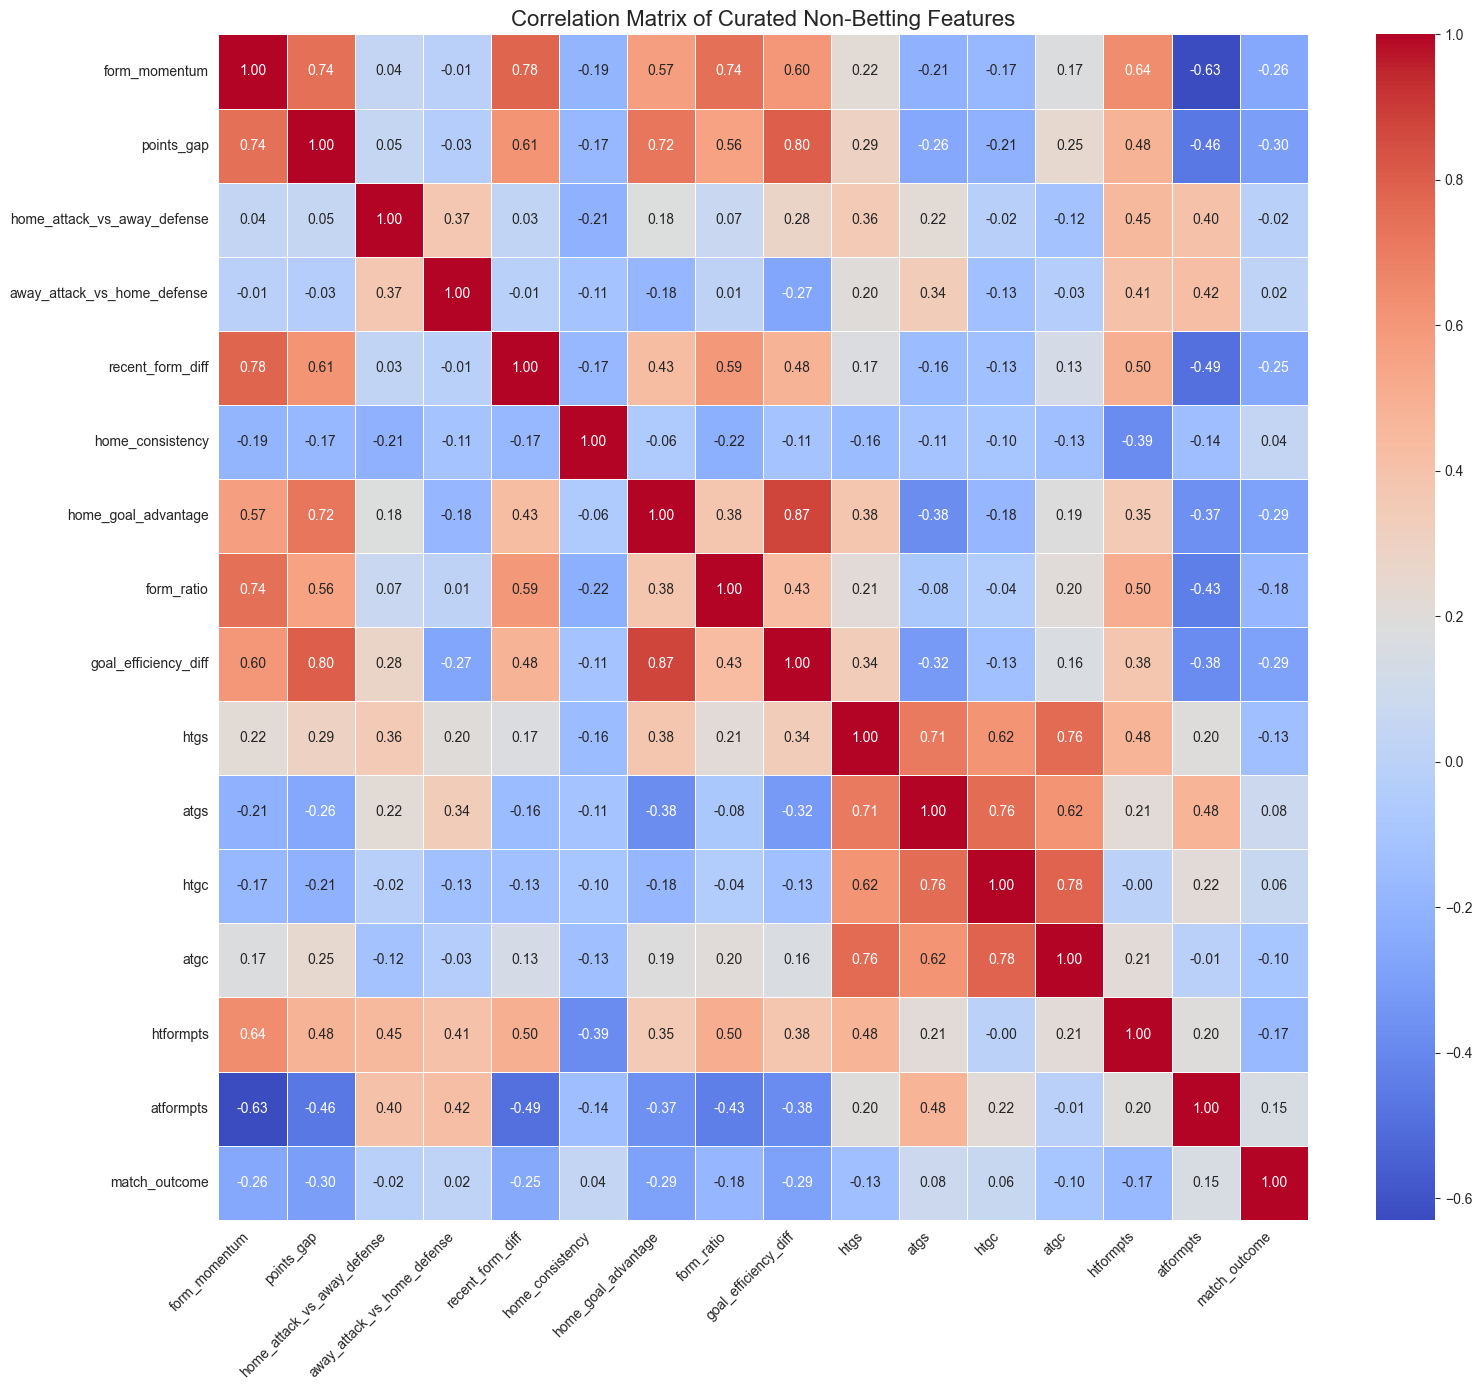

In [10]:
# Cell 3: EDA
# ==================================================

def perform_eda(df, target_col):
    """
    Perform EDA on the dataset, focusing on a curated set of non-betting features.
    """
    print("\n" + "="*80)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*80)
    
    # --- Target Distribution ---
    df_eda = df.copy()
    le = LabelEncoder()
    
    if target_col in df_eda.columns and df_eda[target_col].dtype == 'object':
        df_eda[target_col] = le.fit_transform(df_eda[target_col])
        print(f"Temporarily encoded '{target_col}' for visualization.")

    print(f"\nDistribution of Target Variable: '{target_col}'")
    plt.figure(figsize=(8, 5))
    sns.countplot(x=target_col, data=df, palette='viridis', order=df[target_col].value_counts().index)
    plt.title(f'Distribution of {target_col}')
    plt.xlabel('Match Outcome')
    plt.ylabel('Count')
    plt.show()
    
    # --- Correlation Matrix on a Curated Subset of Non-Betting Features ---
    print("\nGenerating Correlation Matrix for a curated subset of non-betting features...")
    
    curated_features = [
        # Key engineered features
        'form_momentum', 'points_gap', 'home_attack_vs_away_defense', 
        'away_attack_vs_home_defense', 'recent_form_diff', 'home_consistency',
        'home_goal_advantage', 'form_ratio', 'goal_efficiency_diff',
        # Key original stats
        'htgs', 'atgs', 'htgc', 'atgc', 'htformpts', 'atformpts',
        # Target column
        target_col
    ]
    
    # Filter to only features that actually exist in the dataframe
    existing_curated_features = [f for f in curated_features if f in df_eda.columns]
    
    if not existing_curated_features:
        print("! Could not find any of the curated features for correlation analysis. Skipping heatmap.")
        return

    print(f"-> Plotting correlation for {len(existing_curated_features)} features.")
    
    plt.figure(figsize=(16, 14))
    corr_df = df_eda[existing_curated_features].copy()
    corr_df.dropna(axis=1, how='all', inplace=True)
    
    if corr_df.empty:
        print("! All selected columns for correlation were empty. Skipping heatmap.")
        return
        
    corr_matrix = corr_df.corr()
    
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap='coolwarm', 
        fmt='.2f', 
        linewidths=0.5,
        annot_kws={"size": 10}
    )
    plt.title('Correlation Matrix of Curated Non-Betting Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Perform EDA on the dataframe from the previous cell
perform_eda(df, 'match_outcome')


In [4]:
# Cell 4: Feature Engineering & Selection
# ==================================================

def preprocess_data(df, target_col, top_n_features=15):
    """
    Preprocess data for match winner prediction, excluding betting odds and leakage columns.
    """
    print(f"\n{'='*80}")
    print(f"FEATURE ENGINEERING & SELECTION (NO BETTING ODDS)")
    print(f"{'='*80}")
    
    data = df.copy()
    
    # --- Encode Target Variable ---
    if not pd.api.types.is_numeric_dtype(data[target_col]):
        print(f"Encoding target variable '{target_col}'...")
        le = LabelEncoder()
        data[target_col] = le.fit_transform(data[target_col])
        class_names = list(le.classes_)
        print(f"✓ Target classes: {dict(zip(range(len(class_names)), class_names))}")
    else:
        le = None
        class_names = sorted(data[target_col].unique())

    # Drop rows with NaN in target
    data.dropna(subset=[target_col], inplace=True)
    
    # --- Add all betting-related columns to the drop list ---
    betting_cols = [col for col in data.columns if any(prefix in col for prefix in ['b365', 'bw', 'iw', 'lb', 'ps', 'wh', 'sj', 'vc', 'gb', 'bs'])]
    
    # --- CRITICAL: Define Leakage Columns (Match Stats) ---
    # 'fthg' (Full Time Home Goals) and 'ftag' (Full Time Away Goals) are direct leakage.
    leakage_cols = ['fthg', 'ftag', 'home_team_goal', 'away_team_goal']
    
    # Drop non-predictive, leakage, and betting columns
    drop_cols = [
        'match_api_id', 'home_team_api_id', 'away_team_api_id', 
        'date', 
        'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 
        'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
        'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 
        'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11'
    ] + betting_cols + leakage_cols
    
    y = data[target_col]
    X = data.drop(columns=[target_col])
    
    # Drop the specified columns
    initial_drop = sorted(list(set([c for c in drop_cols if c in X.columns])))
    X = X.drop(columns=initial_drop, errors='ignore')
    
    # --- FIX: Identify and drop any remaining non-numeric columns before feature selection ---
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if categorical_cols:
        print(f"\n! Dropping remaining categorical columns before modeling: {categorical_cols}")
        X = X.drop(columns=categorical_cols, errors='ignore')
    
    # Combine all dropped columns for the report
    dropped = sorted(list(set(initial_drop + categorical_cols)))

    # Impute missing values (median for numeric)
    numeric_cols = X.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if X[col].isnull().any():
            median_val = X[col].median()
            X[col].fillna(median_val, inplace=True)
    
    # Feature Selection using Mutual Information
    from sklearn.feature_selection import mutual_info_classif

    print("\nPerforming feature selection with Mutual Information...")
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    # Select top N features
    top_features = mi_scores.head(top_n_features).index.tolist()
    
    # Filter X to only include top features
    X_selected = X[top_features].copy()
    
    # --- In-place non-linear transformations within the selected feature set (no new features) ---
    skew_log_features = ['points_gap', 'diffpts', 'htgd', 'atgd', 'htformpts', 'atp']
    for col in skew_log_features:
        if col in X_selected.columns:
            col_values = X_selected[col].astype(float)
            X_selected[col] = np.sign(col_values) * np.log1p(np.abs(col_values))
    
    print("\n" + "-"*80)
    print("FEATURE SELECTION SUMMARY")
    print("-"*80)
    print(f"Target Column: {target_col}")
    print(f"\nExcluded Columns ({len(dropped)}): {', '.join(dropped)}")
    print(f"\nTop {top_n_features} Selected Features (based on Mutual Information):")
    for i, col in enumerate(X_selected.columns, 1):
        print(f"  {i}. {col} (MI Score: {mi_scores[col]:.4f})")
    print("-"*80)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
    
    # Apply SMOTE only on the training split to avoid leakage
    X_train_final, y_train_final = X_train_scaled, y_train
    if 'SMOTE_AVAILABLE' in globals() and SMOTE_AVAILABLE:
        print("\nApplying SMOTE to training data to handle class imbalance...")
        smote = SMOTE(random_state=RANDOM_STATE)
        X_train_final, y_train_final = smote.fit_resample(X_train_scaled, y_train)
        print(f"Resampled training shape: {X_train_final.shape}")
    else:
        print("\nSMOTE not available, proceeding without resampling.")
    
    print(f"\nTraining Shape: {X_train_final.shape}")
    print(f"Testing Shape: {X_test_scaled.shape}")
    
    return X_train_final, X_test_scaled, y_train_final, y_test, scaler, le

# Preprocess data and select top 15 features
X_train, X_test, y_train, y_test, scaler, label_encoder = preprocess_data(df, 'match_outcome', top_n_features=15)



FEATURE ENGINEERING & SELECTION (NO BETTING ODDS)
Encoding target variable 'match_outcome'...
✓ Target classes: {0: 'H', 1: 'NH'}

! Dropping remaining categorical columns before modeling: ['hometeam', 'awayteam', 'htformptsstr', 'atformptsstr']

Performing feature selection with Mutual Information...

--------------------------------------------------------------------------------
FEATURE SELECTION SUMMARY
--------------------------------------------------------------------------------
Target Column: match_outcome

Excluded Columns (7): atformptsstr, awayteam, date, ftag, fthg, hometeam, htformptsstr

Top 15 Selected Features (based on Mutual Information):
  1. home_goal_advantage (MI Score: 0.0553)
  2. points_gap (MI Score: 0.0515)
  3. points_ratio (MI Score: 0.0503)
  4. diffpts (MI Score: 0.0451)
  5. goal_efficiency_diff (MI Score: 0.0450)
  6. form_momentum (MI Score: 0.0414)
  7. gd_x_formpts (MI Score: 0.0362)
  8. away_goal_advantage (MI Score: 0.0336)
  9. diffformpts (MI 

In [5]:
# Cell 5: Model Training and Tuning
# ==================================================

def train_match_models(X_train, y_train):
    """
    Train and tune match winner models, including a Neural Network (MLP).
    """
    print("\n" + "="*80)
    print("MODEL TRAINING")
    print("="*80)
    
    best_models = {}
    
    # 1. Logistic Regression
    print("\n--- Tuning Logistic Regression ---")
    def lr_params(trial):
        return {
            'C': trial.suggest_float('C', 0.01, 10.0, log=True),
            'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
            'max_iter': 1000
        }
    lr_best_params = tune_hyperparameters(
        LogisticRegression, X_train, y_train, lr_params, n_trials=20, scoring='f1_macro'
    )
    lr_model = LogisticRegression(**lr_best_params)
    lr_model.fit(X_train, y_train)
    best_models['LogisticRegression'] = lr_model
    
    # 2. Random Forest
    print("\n--- Tuning Random Forest ---")
    def rf_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 200, 500),
            'max_depth': trial.suggest_int('max_depth', 10, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }
    rf_best_params = tune_hyperparameters(
        RandomForestClassifier, X_train, y_train, rf_params, n_trials=30, scoring='f1_macro'
    )
    rf_model = RandomForestClassifier(**rf_best_params)
    rf_model.fit(X_train, y_train)
    best_models['RandomForest'] = rf_model
    
    # 3. XGBoost
    if XGB_AVAILABLE:
        print("\n--- Tuning XGBoost ---")
        def xgb_params(trial):
            return {
                'n_estimators': trial.suggest_int('n_estimators', 200, 500),
                'max_depth': trial.suggest_int('max_depth', 5, 15),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
                'random_state': RANDOM_STATE,
                'n_jobs': -1
            }
        xgb_best_params = tune_hyperparameters(
            xgb.XGBClassifier, X_train, y_train, xgb_params, n_trials=30, scoring='f1_macro'
        )
        xgb_model = xgb.XGBClassifier(**xgb_best_params)
        xgb_model.fit(X_train, y_train)
        best_models['XGBoost'] = xgb_model
        
    # 4. Gradient Boosting
    print("\n--- Tuning Gradient Boosting ---")
    def gb_params(trial):
        return {
            'n_estimators': trial.suggest_int('n_estimators', 200, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'random_state': RANDOM_STATE
        }
    gb_best_params = tune_hyperparameters(
        GradientBoostingClassifier, X_train, y_train, gb_params, n_trials=30, scoring='f1_macro'
    )
    gb_model = GradientBoostingClassifier(**gb_best_params)
    gb_model.fit(X_train, y_train)
    best_models['GradientBoosting'] = gb_model
        
    # 5. Neural Network (Deeper MLPClassifier)
    if NN_AVAILABLE:
        print("\n--- Tuning Deep Neural Network (MLP) ---")
        def mlp_params(trial):
            layer1 = trial.suggest_int('layer1', 128, 512, step=64)
            layer2 = trial.suggest_int('layer2', 64, 256, step=32)
            layer3 = trial.suggest_int('layer3', 32, 128, step=32)
            return {
                'hidden_layer_sizes': (layer1, layer2, layer3),
                'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
                'alpha': trial.suggest_float('alpha', 0.0001, 0.01, log=True),
                'learning_rate_init': trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True),
                'learning_rate': trial.suggest_categorical('learning_rate', ['adaptive', 'constant']),
                'max_iter': 500,
                'early_stopping': True,
                'validation_fraction': 0.15,
                'random_state': RANDOM_STATE
            }
        mlp_best_params_raw = tune_hyperparameters(
            MLPClassifier, X_train, y_train, mlp_params, n_trials=30, scoring='f1_macro'
        )
        # Manually construct the correct parameters
        mlp_best_params = {
            'hidden_layer_sizes': (mlp_best_params_raw['layer1'], mlp_best_params_raw['layer2'], mlp_best_params_raw['layer3']),
            'activation': mlp_best_params_raw['activation'],
            'alpha': mlp_best_params_raw['alpha'],
            'learning_rate_init': mlp_best_params_raw['learning_rate_init'],
            'learning_rate': mlp_best_params_raw['learning_rate'],
            'max_iter': 500,
            'early_stopping': True,
            'validation_fraction': 0.15,
            'random_state': RANDOM_STATE
        }
        mlp_model = MLPClassifier(**mlp_best_params)
        mlp_model.fit(X_train, y_train)
        print("✓ Deep Neural Network training complete.")
        best_models['NeuralNetwork'] = mlp_model
    
    # 6. Stacking Ensemble (Meta-Learner)
    print("\n--- Building Stacking Ensemble ---")
    from sklearn.ensemble import StackingClassifier
    
    base_estimators = [
        ('rf', best_models['RandomForest']),
        ('lr', best_models['LogisticRegression'])
    ]
    if 'XGBoost' in best_models:
        base_estimators.append(('xgb', best_models['XGBoost']))
    if 'GradientBoosting' in best_models:
        base_estimators.append(('gb', best_models['GradientBoosting']))
    if 'NeuralNetwork' in best_models:
        base_estimators.append(('nn', best_models['NeuralNetwork']))
    
    # Use Logistic Regression as meta-learner
    stacking_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(C=1.0, max_iter=1000, random_state=RANDOM_STATE),
        cv=7,
        n_jobs=-1
    )
    print(f"Training stacking ensemble with {len(base_estimators)} base models...")
    stacking_model.fit(X_train, y_train)
    best_models['StackingEnsemble'] = stacking_model
    print("✓ Stacking Ensemble training complete.")

    return best_models

# Train all models
best_models = train_match_models(X_train, y_train)


[I 2025-11-20 11:28:00,094] A new study created in memory with name: no-name-54fb5a6b-72ef-488b-b3fd-36aa68619e7c



MODEL TRAINING

--- Tuning Logistic Regression ---


[I 2025-11-20 11:28:02,061] Trial 0 finished with value: 0.6161151510226872 and parameters: {'C': 8.76245429413077, 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.6161151510226872.
[I 2025-11-20 11:28:03,314] Trial 1 finished with value: 0.6156040867351106 and parameters: {'C': 0.6874154529093673, 'solver': 'lbfgs', 'class_weight': None}. Best is trial 0 with value: 0.6161151510226872.
[I 2025-11-20 11:28:04,185] Trial 2 finished with value: 0.6161151510226872 and parameters: {'C': 6.035468458070203, 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6161151510226872.
[I 2025-11-20 11:28:04,222] Trial 3 finished with value: 0.6159445479826521 and parameters: {'C': 1.2580522825513474, 'solver': 'liblinear', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6161151510226872.
[I 2025-11-20 11:28:04,257] Trial 4 finished with value: 0.6161103476852033 and parameters: {'C': 0.7364894873267236, 'solver': 'liblinear', 'class

Best trial:
  Value: 0.6161151510226872
  Params: 
    C: 8.76245429413077
    solver: liblinear
    class_weight: None

--- Tuning Random Forest ---


[I 2025-11-20 11:28:07,949] Trial 0 finished with value: 0.6365682838467777 and parameters: {'n_estimators': 455, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6365682838467777.
[I 2025-11-20 11:28:09,460] Trial 1 finished with value: 0.6285324486297608 and parameters: {'n_estimators': 232, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6365682838467777.
[I 2025-11-20 11:28:12,242] Trial 2 finished with value: 0.6372667663763804 and parameters: {'n_estimators': 386, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6372667663763804.
[I 2025-11-20 11:28:14,353] Trial 3 finished with value: 0.6372317838606661 and parameters: {'n_estimators': 261, 'max_depth': 26, 'min_samples_split': 8, 'min_sam

Best trial:
  Value: 0.6393586715770192
  Params: 
    n_estimators: 486
    max_depth: 30
    min_samples_split: 2
    min_samples_leaf: 3
    max_features: sqrt
    class_weight: balanced_subsample


[I 2025-11-20 11:29:43,792] A new study created in memory with name: no-name-27687feb-ed7e-437d-973a-36913f7b86eb



--- Tuning XGBoost ---


[I 2025-11-20 11:29:44,498] Trial 0 finished with value: 0.6192802304159325 and parameters: {'n_estimators': 318, 'max_depth': 11, 'learning_rate': 0.0166713905999199, 'subsample': 0.8869988215291462, 'colsample_bytree': 0.7866789006528778, 'gamma': 4.975240931974044, 'reg_alpha': 0.7929395026599051, 'reg_lambda': 0.7585383943438758}. Best is trial 0 with value: 0.6192802304159325.
[I 2025-11-20 11:29:45,347] Trial 1 finished with value: 0.6090499199959407 and parameters: {'n_estimators': 469, 'max_depth': 5, 'learning_rate': 0.17639432774017966, 'subsample': 0.9164054813337796, 'colsample_bytree': 0.8098937109997206, 'gamma': 0.535016940231921, 'reg_alpha': 0.45915350047415904, 'reg_lambda': 0.7912894894430248}. Best is trial 0 with value: 0.6192802304159325.
[I 2025-11-20 11:29:45,817] Trial 2 finished with value: 0.6190994790542316 and parameters: {'n_estimators': 260, 'max_depth': 9, 'learning_rate': 0.0544975358304175, 'subsample': 0.9610650257793474, 'colsample_bytree': 0.8358702

Best trial:
  Value: 0.6292236689617433
  Params: 
    n_estimators: 423
    max_depth: 14
    learning_rate: 0.10629467326725697
    subsample: 0.8608861327549315
    colsample_bytree: 0.8667784273200999
    gamma: 4.551133230803888
    reg_alpha: 0.35061695545541327
    reg_lambda: 0.1280870799102528


[I 2025-11-20 11:29:58,460] A new study created in memory with name: no-name-43586192-88fb-4cc7-8fd0-d6cc81f8b13c



--- Tuning Gradient Boosting ---


[I 2025-11-20 11:30:04,732] Trial 0 finished with value: 0.63455172250134 and parameters: {'n_estimators': 256, 'learning_rate': 0.021493914339641915, 'max_depth': 6, 'subsample': 0.7895459384479281}. Best is trial 0 with value: 0.63455172250134.
[I 2025-11-20 11:30:13,006] Trial 1 finished with value: 0.6182327295675398 and parameters: {'n_estimators': 302, 'learning_rate': 0.08885572164895035, 'max_depth': 6, 'subsample': 0.9371172898962509}. Best is trial 0 with value: 0.63455172250134.
[I 2025-11-20 11:30:18,156] Trial 2 finished with value: 0.624231369395282 and parameters: {'n_estimators': 291, 'learning_rate': 0.07498815495507563, 'max_depth': 4, 'subsample': 0.9025916252524998}. Best is trial 0 with value: 0.63455172250134.
[I 2025-11-20 11:30:21,841] Trial 3 finished with value: 0.6207355266444466 and parameters: {'n_estimators': 262, 'learning_rate': 0.1595503473681939, 'max_depth': 4, 'subsample': 0.6738558444357556}. Best is trial 0 with value: 0.63455172250134.
[I 2025-11-

Best trial:
  Value: 0.63455172250134
  Params: 
    n_estimators: 256
    learning_rate: 0.021493914339641915
    max_depth: 6
    subsample: 0.7895459384479281


[I 2025-11-20 11:34:25,580] A new study created in memory with name: no-name-7270c18a-4337-4c2f-b29f-2d46c99b4668



--- Tuning Deep Neural Network (MLP) ---


[I 2025-11-20 11:34:27,208] Trial 0 finished with value: 0.6249167768664412 and parameters: {'layer1': 192, 'layer2': 192, 'layer3': 128, 'activation': 'relu', 'alpha': 0.0005727227747525987, 'learning_rate_init': 0.0008312127735795474, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.6249167768664412.
[I 2025-11-20 11:34:29,774] Trial 1 finished with value: 0.6248802452953687 and parameters: {'layer1': 384, 'layer2': 96, 'layer3': 96, 'activation': 'relu', 'alpha': 0.002565650612690816, 'learning_rate_init': 0.00013999294159735458, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.6249167768664412.
[I 2025-11-20 11:34:33,674] Trial 2 finished with value: 0.6242186902020841 and parameters: {'layer1': 384, 'layer2': 160, 'layer3': 128, 'activation': 'relu', 'alpha': 0.0008462241246299394, 'learning_rate_init': 0.006483000564362855, 'learning_rate': 'constant'}. Best is trial 0 with value: 0.6249167768664412.
[I 2025-11-20 11:34:40,876] Trial 3 finished with value: 0

Best trial:
  Value: 0.6297829514074665
  Params: 
    layer1: 320
    layer2: 96
    layer3: 96
    activation: tanh
    alpha: 0.004323404903640321
    learning_rate_init: 0.0017911962307902176
    learning_rate: constant
✓ Deep Neural Network training complete.

--- Building Stacking Ensemble ---
Training stacking ensemble with 5 base models...
✓ Stacking Ensemble training complete.



EVALUATION

Evaluating LogisticRegression
--- LogisticRegression Evaluation ---
Accuracy: 0.6550
Precision (Weighted): 0.6551
Recall (Weighted): 0.6550
F1 Score (Weighted): 0.6550
F1 Score (Macro): 0.6533

Classification Report:

              precision    recall  f1-score   support

           H       0.63      0.63      0.63       635
          NH       0.68      0.68      0.68       733

    accuracy                           0.65      1368
   macro avg       0.65      0.65      0.65      1368
weighted avg       0.66      0.65      0.66      1368



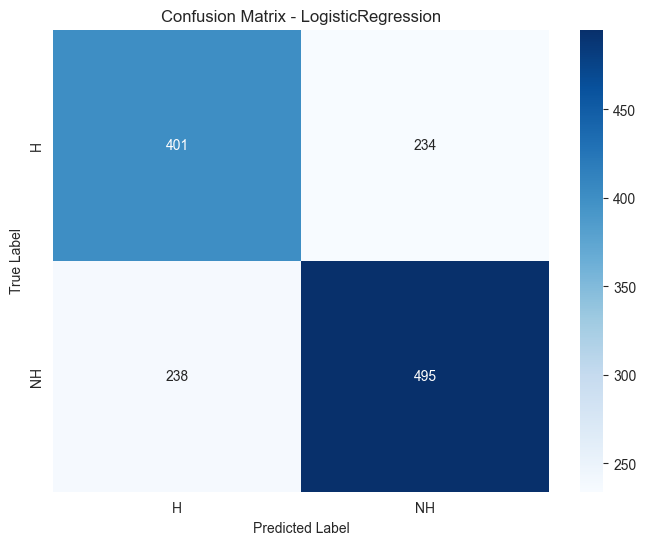


✓ Model saved to: models\match_winner_LogisticRegression.joblib

Evaluating RandomForest
--- RandomForest Evaluation ---
Accuracy: 0.6418
Precision (Weighted): 0.6408
Recall (Weighted): 0.6418
F1 Score (Weighted): 0.6409
F1 Score (Macro): 0.6383

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.59      0.60       635
          NH       0.66      0.69      0.67       733

    accuracy                           0.64      1368
   macro avg       0.64      0.64      0.64      1368
weighted avg       0.64      0.64      0.64      1368



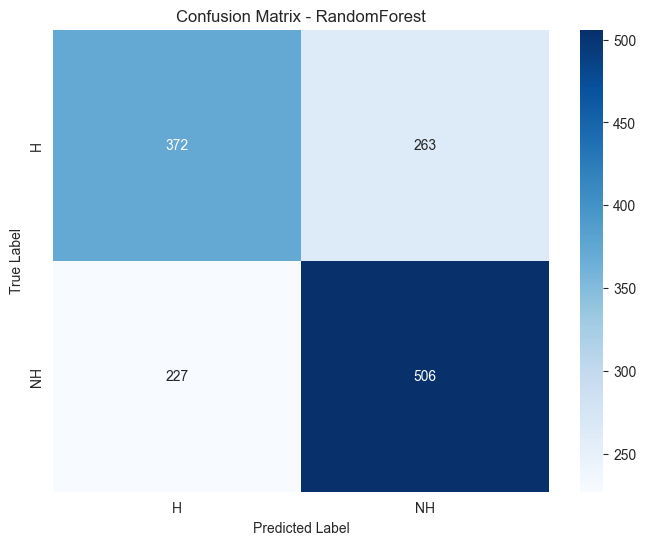


✓ Model saved to: models\match_winner_RandomForest.joblib

Evaluating XGBoost
--- XGBoost Evaluation ---
Accuracy: 0.6272
Precision (Weighted): 0.6269
Recall (Weighted): 0.6272
F1 Score (Weighted): 0.6270
F1 Score (Macro): 0.6249

Classification Report:

              precision    recall  f1-score   support

           H       0.60      0.59      0.60       635
          NH       0.65      0.66      0.65       733

    accuracy                           0.63      1368
   macro avg       0.63      0.62      0.62      1368
weighted avg       0.63      0.63      0.63      1368



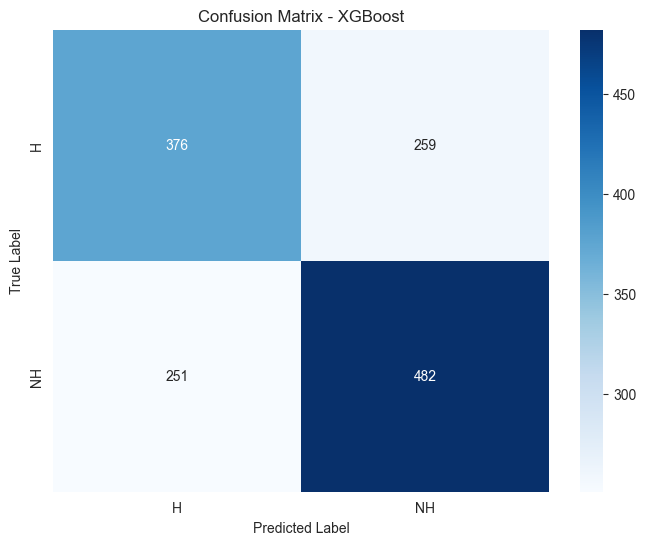


✓ Model saved to: models\match_winner_XGBoost.joblib

Evaluating GradientBoosting
--- GradientBoosting Evaluation ---
Accuracy: 0.6382
Precision (Weighted): 0.6373
Recall (Weighted): 0.6382
F1 Score (Weighted): 0.6374
F1 Score (Macro): 0.6350

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.59      0.60       635
          NH       0.66      0.68      0.67       733

    accuracy                           0.64      1368
   macro avg       0.64      0.63      0.64      1368
weighted avg       0.64      0.64      0.64      1368



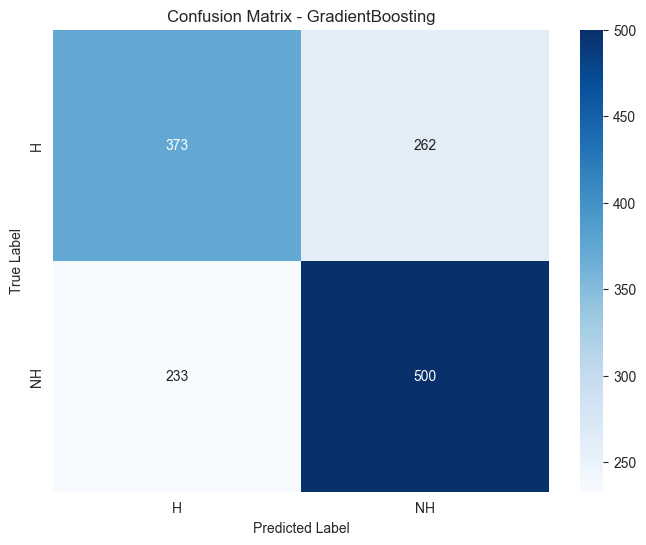


✓ Model saved to: models\match_winner_GradientBoosting.joblib

Evaluating NeuralNetwork
--- NeuralNetwork Evaluation ---
Accuracy: 0.6579
Precision (Weighted): 0.6575
Recall (Weighted): 0.6579
F1 Score (Weighted): 0.6544
F1 Score (Macro): 0.6509

Classification Report:

              precision    recall  f1-score   support

           H       0.65      0.56      0.60       635
          NH       0.66      0.75      0.70       733

    accuracy                           0.66      1368
   macro avg       0.66      0.65      0.65      1368
weighted avg       0.66      0.66      0.65      1368



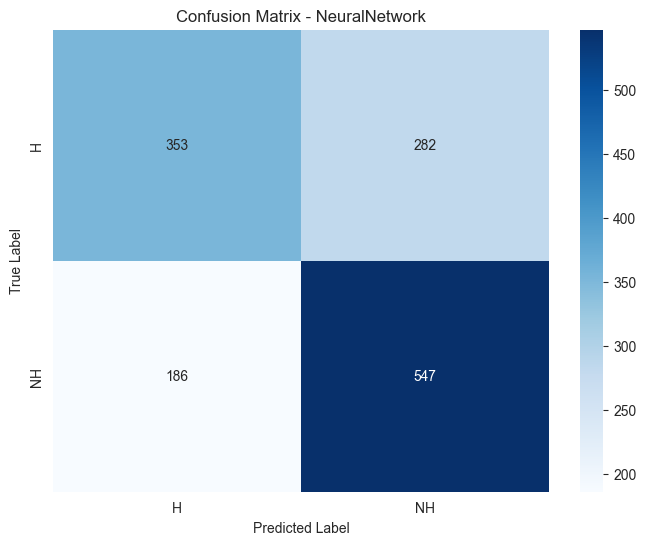


✓ Model saved to: models\match_winner_NeuralNetwork.joblib

Evaluating StackingEnsemble
--- StackingEnsemble Evaluation ---
Accuracy: 0.6447
Precision (Weighted): 0.6440
Recall (Weighted): 0.6447
F1 Score (Weighted): 0.6441
F1 Score (Macro): 0.6418

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.60      0.61       635
          NH       0.66      0.69      0.67       733

    accuracy                           0.64      1368
   macro avg       0.64      0.64      0.64      1368
weighted avg       0.64      0.64      0.64      1368



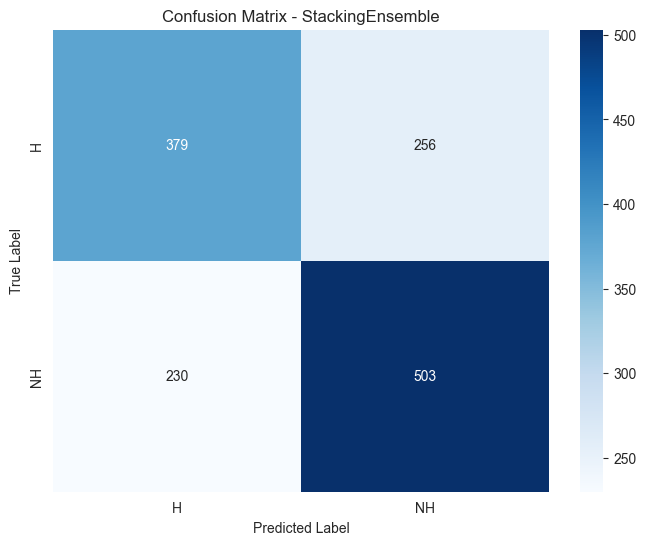


✓ Model saved to: models\match_winner_StackingEnsemble.joblib

Calibrating StackingEnsemble with CalibratedClassifierCV
--- CalibratedStacking Evaluation ---
Accuracy: 0.6491
Precision (Weighted): 0.6484
Recall (Weighted): 0.6491
F1 Score (Weighted): 0.6486
F1 Score (Macro): 0.6463

Classification Report:

              precision    recall  f1-score   support

           H       0.63      0.60      0.61       635
          NH       0.67      0.69      0.68       733

    accuracy                           0.65      1368
   macro avg       0.65      0.65      0.65      1368
weighted avg       0.65      0.65      0.65      1368



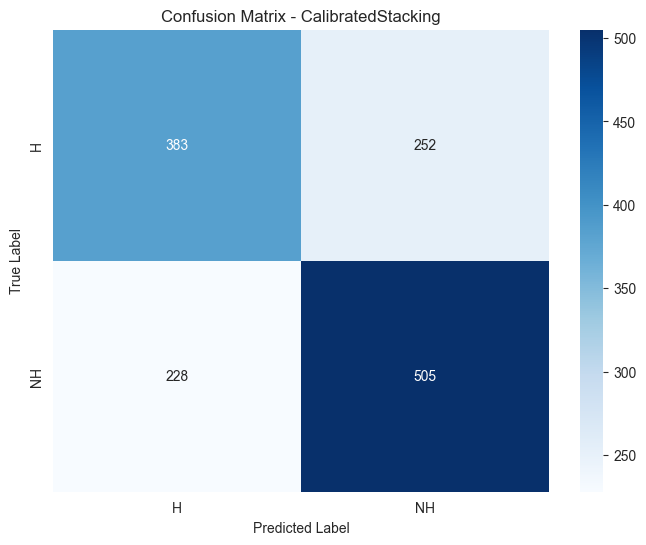


✓ Calibrated ensemble saved to: models\match_winner_CalibratedStacking.joblib

MODEL COMPARISON
                Model  Accuracy  Precision    Recall  F1_Score  F1_Macro
0  LogisticRegression  0.654971   0.655121  0.654971  0.655040  0.653334
1        RandomForest  0.641813   0.640840  0.641813  0.640881  0.638343
2             XGBoost  0.627193   0.626896  0.627193  0.627023  0.624941
3    GradientBoosting  0.638158   0.637296  0.638158  0.637440  0.635012
4       NeuralNetwork  0.657895   0.657550  0.657895  0.654420  0.650873
5    StackingEnsemble  0.644737   0.643969  0.644737  0.644120  0.641794
6  CalibratedStacking  0.649123   0.648416  0.649123  0.648569  0.646310

✓ Comparison saved to: reports\match_winner\model_comparison.csv

🏆 Best Model: LogisticRegression
   F1 Score (Weighted): 0.6550
   F1 Score (Macro): 0.6533
   Accuracy: 0.6550
✓ Best model saved to: models\match_winner_best_model.joblib

✅ MATCH WINNER PIPELINE COMPLETED!


In [6]:
# Cell 6: Evaluation, Calibration, and Model Comparison
# ==================================================

print("\n" + "="*80)
print("EVALUATION")
print("="*80)

metrics_list = []
class_names = list(label_encoder.classes_) if label_encoder is not None else sorted(y_test.unique())

# Evaluate all base models and stacking ensemble
for model_name, model in best_models.items():
    print("\n" + "="*60)
    print(f"Evaluating {model_name}")
    print("="*60)
    metrics = evaluate_classification_model(model, X_test, y_test, model_name=model_name, class_names=class_names)
    metrics_list.append(metrics)
    
    # Save individual models
    model_path = MODELS_DIR / f"match_winner_{model_name}.joblib"
    joblib.dump(model, model_path)
    print(f"\n✓ Model saved to: {model_path}")

# Calibrate the stacking ensemble for better probabilities and F1
if 'StackingEnsemble' in best_models:
    print("\n" + "="*60)
    print("Calibrating StackingEnsemble with CalibratedClassifierCV")
    print("="*60)
    cv_calib = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    calibrated_stacking = CalibratedClassifierCV(best_models['StackingEnsemble'], cv=cv_calib, method='sigmoid')
    calibrated_stacking.fit(X_train, y_train)
    best_models['CalibratedStacking'] = calibrated_stacking
    
    metrics = evaluate_classification_model(calibrated_stacking, X_test, y_test, model_name="CalibratedStacking", class_names=class_names)
    metrics_list.append(metrics)
    
    calibrated_path = MODELS_DIR / "match_winner_CalibratedStacking.joblib"
    joblib.dump(calibrated_stacking, calibrated_path)
    print(f"\n✓ Calibrated ensemble saved to: {calibrated_path}")

# Build comparison dataframe
metrics_df = pd.DataFrame(metrics_list)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(metrics_df)

# Persist comparison
comparison_path = REPORTS_DIR / "model_comparison.csv"
metrics_df.to_csv(comparison_path, index=False)
print(f"\n✓ Comparison saved to: {comparison_path}")

# Select best model by F1 Score (weighted), break ties with F1 Macro, then Accuracy
metrics_df_sorted = metrics_df.sort_values(by=["F1_Score", "F1_Macro", "Accuracy"], ascending=False)
best_row = metrics_df_sorted.iloc[0]
best_model_name = best_row['Model']

print("\n🏆 Best Model:", best_model_name)
print(f"   F1 Score (Weighted): {best_row['F1_Score']:.4f}")
print(f"   F1 Score (Macro): {best_row['F1_Macro']:.4f}")
print(f"   Accuracy: {best_row['Accuracy']:.4f}")

best_model = best_models[best_model_name]
best_model_path = MODELS_DIR / "match_winner_best_model.joblib"
joblib.dump(best_model, best_model_path)
print(f"✓ Best model saved to: {best_model_path}")

# Save simple metadata for reproducibility
metadata = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "best_model": best_model_name,
    "metrics": best_row.to_dict(),
    "features_used": list(X_train.columns),
    "random_state": RANDOM_STATE
}

metadata_path = MODELS_DIR / "ps4_match_winner_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print("\n" + "="*80)
print("✅ MATCH WINNER PIPELINE COMPLETED!")
print("="*80)



DIAGNOSTICS
Saved feature correlation matrix to: reports\match_winner\diagnostics\feature_correlation.csv
Saved correlation heatmap to: reports\match_winner\diagnostics\feature_correlation_heatmap.png

Computing permutation importance for LogisticRegression (test set)...


[I 2025-11-20 12:46:36,794] A new study created in memory with name: no-name-270b63df-d805-4cb1-8057-339c9ac33cf5


Saved permutation importance to: reports\match_winner\diagnostics\lr_permutation_importance.csv

Candidate features to drop (permutation-based): ['htgd', 'form_momentum', 'form_ratio']

Training ElasticNet LogisticRegression on pruned feature set (12 features)...


[I 2025-11-20 12:46:43,931] Trial 0 finished with value: 0.6153018964733847 and parameters: {'C': 0.3025546672395648, 'l1_ratio': 0.31399746104367854, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6153018964733847.
[I 2025-11-20 12:46:45,427] Trial 1 finished with value: 0.6147904608905401 and parameters: {'C': 0.5909983336657473, 'l1_ratio': 0.7900557269599264, 'class_weight': None}. Best is trial 0 with value: 0.6153018964733847.
[I 2025-11-20 12:46:46,521] Trial 2 finished with value: 0.6161153651753046 and parameters: {'C': 0.04560882614528126, 'l1_ratio': 0.6205766324919525, 'class_weight': None}. Best is trial 2 with value: 0.6161153651753046.
[I 2025-11-20 12:46:46,570] Trial 3 finished with value: 0.6156513092940353 and parameters: {'C': 4.129721254546473, 'l1_ratio': 0.7374376166240759, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6161153651753046.
[I 2025-11-20 12:46:46,616] Trial 4 finished with value: 0.6154805571540055 and parameters: {'C': 5.106


Best ElasticNet LR params: {'C': 0.012019975108671858, 'l1_ratio': 0.9667037961993259, 'class_weight': 'balanced'}
ElasticNet LR Repeated CV F1_macro: mean=0.6203, std=0.0144
--- ElasticNetLR_Pruned Evaluation ---
Accuracy: 0.6506
Precision (Weighted): 0.6506
Recall (Weighted): 0.6506
F1 Score (Weighted): 0.6506
F1 Score (Macro): 0.6488

Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.62      0.62       635
          NH       0.67      0.67      0.67       733

    accuracy                           0.65      1368
   macro avg       0.65      0.65      0.65      1368
weighted avg       0.65      0.65      0.65      1368



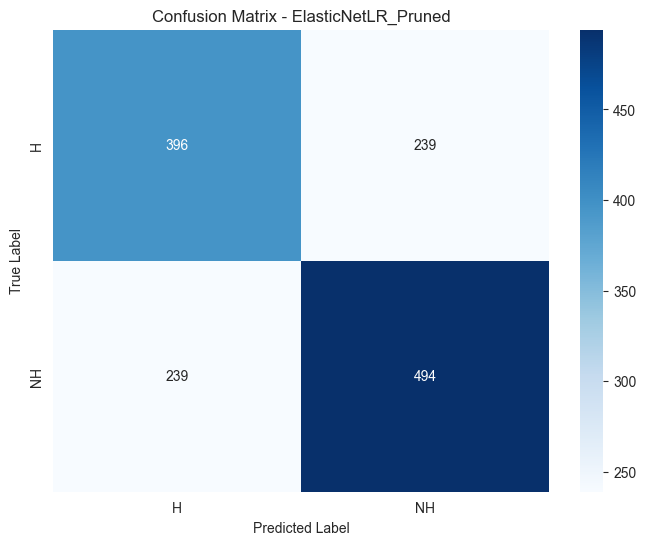


✓ ElasticNet LR (pruned) saved to: models\match_winner_ElasticNetLR_Pruned.joblib
Saved ElasticNet LR summary to: reports\match_winner\diagnostics\elasticnet_lr_pruned_summary.json

Running time-based split diagnostics...

Time-based split performance (LogisticRegression, class_weight='balanced'):
--- LR_TimeSplit Evaluation ---
Accuracy: 0.6301
Precision (Weighted): 0.6332
Recall (Weighted): 0.6301
F1 Score (Weighted): 0.6310
F1 Score (Macro): 0.6281

Classification Report:

              precision    recall  f1-score   support

           H       0.58      0.62      0.60       612
          NH       0.68      0.64      0.66       756

    accuracy                           0.63      1368
   macro avg       0.63      0.63      0.63      1368
weighted avg       0.63      0.63      0.63      1368



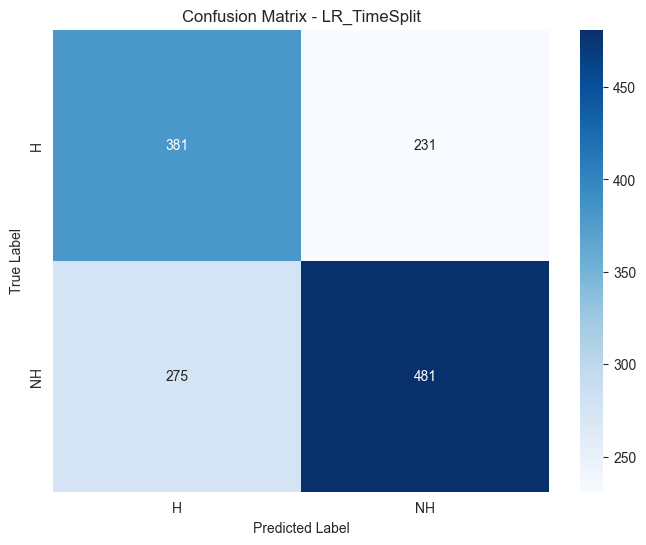

Saved time-split metrics to: reports\match_winner\diagnostics\time_split_lr_metrics.json

Comparing LR with SMOTE vs class_weight='balanced' (random CV)...
Saved SMOTE vs class_weight comparison to: reports\match_winner\diagnostics\lr_smote_vs_balanced.json
Saved calibration curve for LogisticRegression to: reports\match_winner\diagnostics\calibration_curve_LogisticRegression.png
Saved calibration curve for CalibratedStacking to: reports\match_winner\diagnostics\calibration_curve_CalibratedStacking.png
Saved calibration Brier scores to: reports\match_winner\diagnostics\calibration_brier_scores.csv

Evaluating simple baselines on test set...
Saved baseline benchmarks to: reports\match_winner\diagnostics\baseline_benchmarks.csv

Diagnostics completed. Review CSV/PNG files under:
  reports\match_winner\diagnostics


In [11]:
# Cell 7: Diagnostics – Feature Redundancy, Signal Limits, Robustness, Calibration, Baselines
# ==================================================

print("\n" + "="*80)
print("DIAGNOSTICS")
print("="*80)

# Ensure diagnostics directory exists
DIAG_DIR.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# 1. Correlation among current features
# --------------------------------------------------

feature_corr = X_train.corr()
feature_corr_path = DIAG_DIR / "feature_correlation.csv"
feature_corr.to_csv(feature_corr_path)
print(f"Saved feature correlation matrix to: {feature_corr_path}")

plt.figure(figsize=(10, 8))
sns.heatmap(feature_corr, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
corr_fig_path = DIAG_DIR / "feature_correlation_heatmap.png"
plt.savefig(corr_fig_path, dpi=150)
plt.close()
print(f"Saved correlation heatmap to: {corr_fig_path}")

# --------------------------------------------------
# 2. Permutation importance for LogisticRegression
# --------------------------------------------------

if 'LogisticRegression' in best_models:
    lr_model = best_models['LogisticRegression']
    print("\nComputing permutation importance for LogisticRegression (test set)...")
    perm_result = permutation_importance(
        lr_model, X_test, y_test,
        scoring='f1_macro', n_repeats=20, random_state=RANDOM_STATE
    )
    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    }).sort_values('importance_mean', ascending=False)
    perm_path = DIAG_DIR / "lr_permutation_importance.csv"
    perm_df.to_csv(perm_path, index=False)
    print(f"Saved permutation importance to: {perm_path}")

    # Identify weakest features (near-zero or negative importance)
    weak_features = perm_df.tail(5)
    weak_features_to_drop = weak_features[weak_features['importance_mean'] <= 0]['feature'].tolist()
    if len(weak_features_to_drop) < 2:
        weak_features_to_drop = perm_df.tail(3)['feature'].tolist()
    weak_features_to_drop = weak_features_to_drop[:5]
    print("\nCandidate features to drop (permutation-based):", weak_features_to_drop)
else:
    print("LogisticRegression not found in best_models; skipping permutation importance.")
    perm_df = None
    weak_features_to_drop = []

# --------------------------------------------------
# 3. ElasticNet Logistic Regression with feature pruning
# --------------------------------------------------

if 'LogisticRegression' in best_models and len(weak_features_to_drop) > 0:
    X_train_pruned = X_train.drop(columns=[f for f in weak_features_to_drop if f in X_train.columns])
    X_test_pruned = X_test.drop(columns=[f for f in weak_features_to_drop if f in X_test.columns])
    print(f"\nTraining ElasticNet LogisticRegression on pruned feature set ({X_train_pruned.shape[1]} features)...")

    def elasticnet_objective(trial):
        C = trial.suggest_float('C', 0.01, 10.0, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
        model = LogisticRegression(
            penalty='elasticnet', solver='saga',
            C=C, l1_ratio=l1_ratio,
            class_weight=class_weight,
            max_iter=2000,
            random_state=RANDOM_STATE
        )
        cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_val_score(model, X_train_pruned, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(elasticnet_objective, n_trials=25)

    best_params = study.best_params
    print("\nBest ElasticNet LR params:", best_params)

    enet_lr = LogisticRegression(
        penalty='elasticnet', solver='saga',
        C=best_params['C'], l1_ratio=best_params['l1_ratio'],
        class_weight=best_params['class_weight'],
        max_iter=2000,
        random_state=RANDOM_STATE
    )

    rcv = RepeatedStratifiedKFold(n_splits=7, n_repeats=5, random_state=RANDOM_STATE)
    rcv_scores = cross_val_score(enet_lr, X_train_pruned, y_train, cv=rcv, scoring='f1_macro', n_jobs=-1)
    print(f"ElasticNet LR Repeated CV F1_macro: mean={rcv_scores.mean():.4f}, std={rcv_scores.std():.4f}")

    enet_lr.fit(X_train_pruned, y_train)
    enet_metrics = evaluate_classification_model(enet_lr, X_test_pruned, y_test, model_name="ElasticNetLR_Pruned", class_names=class_names)

    enet_path = MODELS_DIR / "match_winner_ElasticNetLR_Pruned.joblib"
    joblib.dump(enet_lr, enet_path)
    print(f"\n✓ ElasticNet LR (pruned) saved to: {enet_path}")

    enet_summary = {
        'mean_f1_macro_cv': float(rcv_scores.mean()),
        'std_f1_macro_cv': float(rcv_scores.std()),
        'test_metrics': enet_metrics,
        'dropped_features': weak_features_to_drop,
        'remaining_features': list(X_train_pruned.columns)
    }
    enet_summary_path = DIAG_DIR / "elasticnet_lr_pruned_summary.json"
    with open(enet_summary_path, 'w') as f:
        json.dump(enet_summary, f, indent=4)
    print(f"Saved ElasticNet LR summary to: {enet_summary_path}")
else:
    print("\nSkipping ElasticNet LR diagnostics (no weak features or LR not available).")

# --------------------------------------------------
# 4. Time-based train/test split to test for leakage
# --------------------------------------------------

if 'date' in df.columns:
    print("\nRunning time-based split diagnostics...")
    df_time = df.copy()
    df_time = df_time.sort_values('date')
    mask = df_time['match_outcome'].notna()
    df_time = df_time[mask]

    # Recreate numeric feature set similar to preprocess_data
    data_time = df_time.copy()
    y_time = data_time['match_outcome']
    X_time = data_time.drop(columns=['match_outcome'])

    # Drop non-numeric and obvious IDs/betting/leakage again
    betting_cols_time = [col for col in X_time.columns if any(prefix in col for prefix in ['b365', 'bw', 'iw', 'lb', 'ps', 'wh', 'sj', 'vc', 'gb', 'bs'])]
    leakage_cols_time = ['fthg', 'ftag', 'home_team_goal', 'away_team_goal']
    drop_cols_time = betting_cols_time + leakage_cols_time
    X_time = X_time.drop(columns=[c for c in drop_cols_time if c in X_time.columns], errors='ignore')
    X_time = X_time.select_dtypes(include=[np.number])

    # Impute
    for col in X_time.columns:
        if X_time[col].isnull().any():
            X_time[col].fillna(X_time[col].median(), inplace=True)

    # Select the same columns as X_train where possible
    common_cols = [c for c in X_train.columns if c in X_time.columns]
    X_time = X_time[common_cols]

    n_time = len(df_time)
    split_idx = int(n_time * 0.8)
    X_train_time = X_time.iloc[:split_idx]
    y_train_time = y_time.iloc[:split_idx]
    X_test_time = X_time.iloc[split_idx:]
    y_test_time = y_time.iloc[split_idx:]

    scaler_time = StandardScaler()
    X_train_time_scaled = pd.DataFrame(
        scaler_time.fit_transform(X_train_time),
        columns=X_train_time.columns,
        index=X_train_time.index
    )
    X_test_time_scaled = pd.DataFrame(
        scaler_time.transform(X_test_time),
        columns=X_test_time.columns,
        index=X_test_time.index
    )

    lr_time = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=RANDOM_STATE)
    lr_time.fit(X_train_time_scaled, y_train_time)

    print("\nTime-based split performance (LogisticRegression, class_weight='balanced'):")
    time_metrics = evaluate_classification_model(lr_time, X_test_time_scaled, y_test_time, model_name="LR_TimeSplit", class_names=class_names)

    time_path = DIAG_DIR / "time_split_lr_metrics.json"
    with open(time_path, 'w') as f:
        json.dump(time_metrics, f, indent=4)
    print(f"Saved time-split metrics to: {time_path}")
else:
    print("\nTime-based diagnostics skipped: 'date' column not available in df.")

# --------------------------------------------------
# 5. LR with/without oversampling – SMOTE vs class_weight
# --------------------------------------------------

print("\nComparing LR with SMOTE vs class_weight='balanced' (random CV)...")

# Baseline: class_weight='balanced', no SMOTE
lr_balanced = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=RANDOM_STATE)
cv_balanced = StratifiedKFold(n_splits=7, shuffle=True, random_state=RANDOM_STATE)
cv_scores_bal = cross_val_score(lr_balanced, X_train, y_train, cv=cv_balanced, scoring='f1_macro', n_jobs=-1)

# With SMOTE: reapply SMOTE within CV (simple approximation)
from imblearn.pipeline import Pipeline as ImbPipeline

lr_smote = LogisticRegression(C=1.0, max_iter=1000, class_weight=None, solver='lbfgs', random_state=RANDOM_STATE)
steps = [
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('lr', lr_smote)
]
imb_pipe = ImbPipeline(steps=steps)
cv_scores_smote = cross_val_score(imb_pipe, X_train, y_train, cv=cv_balanced, scoring='f1_macro', n_jobs=-1)

smote_comparison = {
    'lr_balanced_mean_f1_macro': float(cv_scores_bal.mean()),
    'lr_balanced_std_f1_macro': float(cv_scores_bal.std()),
    'lr_smote_mean_f1_macro': float(cv_scores_smote.mean()),
    'lr_smote_std_f1_macro': float(cv_scores_smote.std())
}

smote_cmp_path = DIAG_DIR / "lr_smote_vs_balanced.json"
with open(smote_cmp_path, 'w') as f:
    json.dump(smote_comparison, f, indent=4)
print(f"Saved SMOTE vs class_weight comparison to: {smote_cmp_path}")

# --------------------------------------------------
# 6. Calibration diagnostics – Brier score and reliability curves
# --------------------------------------------------

calibration_results = []
models_to_calibrate = []

if 'LogisticRegression' in best_models:
    models_to_calibrate.append(('LogisticRegression', best_models['LogisticRegression']))
if 'CalibratedStacking' in best_models:
    models_to_calibrate.append(('CalibratedStacking', best_models['CalibratedStacking']))

for name, model in models_to_calibrate:
    if not hasattr(model, 'predict_proba'):
        continue
    y_prob = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_prob)
    calibration_results.append({'Model': name, 'BrierScore': brier})

    frac_pos, mean_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

    plt.figure(figsize=(6, 6))
    plt.plot(mean_pred, frac_pos, "s-", label=name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    plt.xlabel('Predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve - {name}')
    plt.legend()
    plt.tight_layout()
    calib_plot_path = DIAG_DIR / f"calibration_curve_{name}.png"
    plt.savefig(calib_plot_path, dpi=150)
    plt.close()
    print(f"Saved calibration curve for {name} to: {calib_plot_path}")

calib_df = pd.DataFrame(calibration_results)
calib_path = DIAG_DIR / "calibration_brier_scores.csv"
calib_df.to_csv(calib_path, index=False)
print(f"Saved calibration Brier scores to: {calib_path}")

# --------------------------------------------------
# 7. Baseline benchmarks
# --------------------------------------------------

print("\nEvaluating simple baselines on test set...")

# Majority class baseline
majority_class = y_train.value_counts().idxmax()
y_pred_majority = np.full_like(y_test, fill_value=majority_class)

acc_majority = accuracy_score(y_test, y_pred_majority)
f1_majority = f1_score(y_test, y_pred_majority, average='weighted')

# All-home baseline (assume label corresponding to 'H')
if label_encoder is not None and 'H' in list(label_encoder.classes_):
    home_label = label_encoder.transform(['H'])[0]
else:
    home_label = y_train.value_counts().idxmax()

y_pred_home = np.full_like(y_test, fill_value=home_label)
acc_home = accuracy_score(y_test, y_pred_home)
f1_home = f1_score(y_test, y_pred_home, average='weighted')

# Random baseline following training priors
probs = y_train.value_counts(normalize=True).sort_index().values
rng = np.random.default_rng(RANDOM_STATE)
y_pred_rand = rng.choice(sorted(y_train.unique()), size=len(y_test), p=probs)
acc_rand = accuracy_score(y_test, y_pred_rand)
f1_rand = f1_score(y_test, y_pred_rand, average='weighted')

baseline_rows = [
    {'Model': 'MajorityClass', 'Accuracy': acc_majority, 'F1_Weighted': f1_majority},
    {'Model': 'AllHome', 'Accuracy': acc_home, 'F1_Weighted': f1_home},
    {'Model': 'RandomPrior', 'Accuracy': acc_rand, 'F1_Weighted': f1_rand}
]

baseline_df = pd.DataFrame(baseline_rows)
baseline_path = DIAG_DIR / "baseline_benchmarks.csv"
baseline_df.to_csv(baseline_path, index=False)
print(f"Saved baseline benchmarks to: {baseline_path}")

print("\nDiagnostics completed. Review CSV/PNG files under:")
print(f"  {DIAG_DIR}")
